In [2]:
pip install pytorch-lightning  

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pytorch-forecasting

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

import warnings
warnings.filterwarnings('ignore')

import pickle

import numpy as np
import pandas as pd
from typing import Dict, Callable, List, Optional, Tuple, Union

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import torch

import pytorch_lightning as pl

In [81]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger('.', name = 'DeepAR')

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, distributions, BaseEstimator
# 하나의 시계열을 fitting하므로 NormalDistributionLoss이면 됨
from pytorch_forecasting.metrics import NormalDistributionLoss

In [8]:
df=pd.read_excel('./data_full.xlsx')
df.head()

,Date,Account DOW,REV OBD,OBD NET+FSC_KRW,OBD A/R_KRW,REV CPN,CPN NET+FSC_KRW,CPN A/R_KRW,REV TKT,TKT NET+FSC_KRW,TKT A/R_KRW,WTI,exchanges,kospi,rates,stock_a,stock_k,stock_kkj
0,2016-01-01,FRI,25196,9.923237e+09,393841.7444,5517,2.410238e+09,436874.6714,3188,2.236210e+09,701446.0183,0.00,0.0,0.00,0.00,0,0,0
1,2016-01-02,SAT,27495,1.106671e+10,402499.1654,6320,2.500112e+09,395587.3387,3577,2.405358e+09,672451.2796,0.00,0.0,0.00,0.00,0,0,0
2,2016-01-03,SUN,31843,1.270800e+10,399083.0044,4292,1.813688e+09,422573.9862,2521,1.697046e+09,673163.7338,0.00,0.0,0.00,0.00,0,0,0
3,2016-01-04,MON,28000,1.154173e+10,412204.5697,36263,1.465623e+10,404164.9715,19528,1.454451e+10,744803.0601,36.76,1189.5,1918.76,1.63,21429,16459,108918
4,2016-01-05,TUE,24657,1.008791e+10,409129.4946,38432,1.538667e+10,400360.8701,20461,1.555175e+10,760067.7182,35.97,1189.5,1930.53,1.64,20881,16186,108918


In [9]:
df.shape

(1858, 18)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858 entries, 0 to 1857
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1858 non-null   datetime64[ns]
 1   Account DOW      1858 non-null   object        
 2   REV OBD          1858 non-null   int64         
 3   OBD NET+FSC_KRW  1858 non-null   float64       
 4   OBD A/R_KRW      1858 non-null   float64       
 5   REV CPN          1858 non-null   int64         
 6   CPN NET+FSC_KRW  1858 non-null   float64       
 7   CPN A/R_KRW      1858 non-null   float64       
 8   REV TKT          1858 non-null   int64         
 9   TKT NET+FSC_KRW  1858 non-null   float64       
 10  TKT A/R_KRW      1858 non-null   float64       
 11  WTI              1858 non-null   float64       
 12  exchanges        1858 non-null   float64       
 13  kospi            1858 non-null   float64       
 14  rates            1858 non-null   float64

In [11]:
df = df[df["Date"].isin(pd.date_range('2016-01-4', '2019-11-30'))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1427 entries, 3 to 1429
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             1427 non-null   datetime64[ns]
 1   Account DOW      1427 non-null   object        
 2   REV OBD          1427 non-null   int64         
 3   OBD NET+FSC_KRW  1427 non-null   float64       
 4   OBD A/R_KRW      1427 non-null   float64       
 5   REV CPN          1427 non-null   int64         
 6   CPN NET+FSC_KRW  1427 non-null   float64       
 7   CPN A/R_KRW      1427 non-null   float64       
 8   REV TKT          1427 non-null   int64         
 9   TKT NET+FSC_KRW  1427 non-null   float64       
 10  TKT A/R_KRW      1427 non-null   float64       
 11  WTI              1427 non-null   float64       
 12  exchanges        1427 non-null   float64       
 13  kospi            1427 non-null   float64       
 14  rates            1427 non-null   float64

In [12]:
df.reset_index(drop=True, inplace=True)

In [13]:
df['time_index'] = np.arange(len(df))
df

,Date,Account DOW,REV OBD,OBD NET+FSC_KRW,OBD A/R_KRW,REV CPN,CPN NET+FSC_KRW,CPN A/R_KRW,REV TKT,TKT NET+FSC_KRW,TKT A/R_KRW,WTI,exchanges,kospi,rates,stock_a,stock_k,stock_kkj,time_index
0,2016-01-04,MON,28000,1.154173e+10,412204.5697,36263,1.465623e+10,404164.9715,19528,1.454451e+10,744803.0601,36.76,1189.5,1918.76,1.63,21429,16459,108918,0
1,2016-01-05,TUE,24657,1.008791e+10,409129.4946,38432,1.538667e+10,400360.8701,20461,1.555175e+10,760067.7182,35.97,1189.5,1930.53,1.64,20881,16186,108918,1
2,2016-01-06,WED,26920,1.009247e+10,374905.8415,41478,1.597113e+10,385050.5604,21953,1.647945e+10,750669.3999,33.97,1200.0,1925.43,1.64,20785,16063,110383,2
3,2016-01-07,THU,26624,1.060220e+10,398219.6596,49006,1.798140e+10,366922.4713,25917,1.872443e+10,722476.6906,33.27,1200.2,1904.33,1.64,20809,16003,104522,3
4,2016-01-08,FRI,28879,1.077601e+10,373143.3549,63847,2.480722e+10,388541.6089,33748,2.598923e+10,770096.9727,33.16,1199.5,1917.62,1.67,20523,15637,105499,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,2019-11-26,TUE,22295,7.106925e+09,318767.6722,33929,1.501046e+10,442407.9889,18388,1.618648e+10,880274.0396,58.41,1177.5,2121.35,1.48,26679,16567,47670,1422
1423,2019-11-27,WED,25134,8.100108e+09,322276.9318,35642,1.487445e+10,417329.2423,19304,1.609138e+10,833577.7006,58.11,1177.5,2127.85,1.46,26250,16438,46986,1423
1424,2019-11-28,THU,24742,8.116231e+09,328034.5456,35459,1.549214e+10,436902.7653,19087,1.674230e+10,877157.3571,58.11,1179.0,2118.60,1.43,26059,16470,46937,1424
1425,2019-11-29,FRI,29624,9.924881e+09,335028.3726,41190,1.766483e+10,428862.0799,22167,1.915980e+10,864338.9685,55.17,1180.0,2087.96,1.39,25391,16048,47426,1425


In [14]:
df.keys()

Index(['Date', 'Account DOW', 'REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW',
       'REV CPN', 'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT',
       'TKT NET+FSC_KRW', 'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
       'stock_a', 'stock_k', 'stock_kkj', 'time_index'],
      dtype='object')

#### Scaled된 데이터로 변환

In [15]:
# Scaling
scaler = MinMaxScaler()
scale_col = ['REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW', 'REV CPN',
             'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT', 'TKT NET+FSC_KRW',
             'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
             'stock_a', 'stock_k', 'stock_kkj']
scaled = scaler.fit_transform(df[scale_col])

In [16]:
scaled.shape

(1427, 16)

In [17]:
tmp_df_1 = df[['time_index', 'Date', 'Account DOW']]
columns = ['REV OBD', 'OBD NET+FSC_KRW', 'OBD A/R_KRW', 'REV CPN',
           'CPN NET+FSC_KRW', 'CPN A/R_KRW', 'REV TKT', 'TKT NET+FSC_KRW',
           'TKT A/R_KRW', 'WTI', 'exchanges', 'kospi', 'rates',
           'stock_a', 'stock_k', 'stock_kkj']
tmp_df_2 = pd.DataFrame(scaled, columns=columns)
res_data = pd.concat([tmp_df_1, tmp_df_2], axis=1)
res_data.head()

,time_index,Date,Account DOW,REV OBD,OBD NET+FSC_KRW,OBD A/R_KRW,REV CPN,CPN NET+FSC_KRW,CPN A/R_KRW,REV TKT,TKT NET+FSC_KRW,TKT A/R_KRW,WTI,exchanges,kospi,rates,stock_a,stock_k,stock_kkj
0,0,2016-01-04,MON,0.346259,0.326659,0.374062,0.382432,0.410254,0.477330,0.390738,0.500458,0.532091,0.210159,0.722372,0.109423,0.439024,0.223500,0.211446,0.847607
1,1,2016-01-05,TUE,0.218042,0.241049,0.366526,0.407230,0.432465,0.456675,0.411128,0.506018,0.533700,0.194422,0.722372,0.124851,0.447154,0.200986,0.186607,0.847607
2,2,2016-01-06,WED,0.304836,0.241318,0.282653,0.442056,0.450237,0.373548,0.443735,0.511139,0.532709,0.154582,0.778976,0.118166,0.447154,0.197042,0.175416,0.865189
3,3,2016-01-07,THU,0.293484,0.271334,0.339789,0.528126,0.511364,0.275121,0.530367,0.523532,0.529736,0.140637,0.780054,0.090509,0.447154,0.198028,0.169957,0.794849
4,4,2016-01-08,FRI,0.379972,0.281569,0.278334,0.697807,0.718921,0.392503,0.701510,0.563636,0.534758,0.138446,0.776280,0.107929,0.471545,0.186278,0.136657,0.806574


In [18]:
res_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time_index       1427 non-null   int64         
 1   Date             1427 non-null   datetime64[ns]
 2   Account DOW      1427 non-null   object        
 3   REV OBD          1427 non-null   float64       
 4   OBD NET+FSC_KRW  1427 non-null   float64       
 5   OBD A/R_KRW      1427 non-null   float64       
 6   REV CPN          1427 non-null   float64       
 7   CPN NET+FSC_KRW  1427 non-null   float64       
 8   CPN A/R_KRW      1427 non-null   float64       
 9   REV TKT          1427 non-null   float64       
 10  TKT NET+FSC_KRW  1427 non-null   float64       
 11  TKT A/R_KRW      1427 non-null   float64       
 12  WTI              1427 non-null   float64       
 13  exchanges        1427 non-null   float64       
 14  kospi            1427 non-null   float64

In [19]:
res_data.describe()

,time_index,REV OBD,OBD NET+FSC_KRW,OBD A/R_KRW,REV CPN,CPN NET+FSC_KRW,CPN A/R_KRW,REV TKT,TKT NET+FSC_KRW,TKT A/R_KRW,WTI,exchanges,kospi,rates,stock_a,stock_k,stock_kkj
count,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000
mean,713.000000,0.360195,0.282904,0.292380,0.314459,0.335520,0.418474,0.320825,0.492223,0.534719,0.552898,0.452095,0.456563,0.516457,0.282264,0.489028,0.467030
std,412.083729,0.149388,0.133402,0.106898,0.198184,0.217978,0.174246,0.200160,0.046340,0.020388,0.191520,0.210885,0.246101,0.253865,0.128560,0.236769,0.226520
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,356.500000,0.252905,0.189293,0.218024,0.074551,0.064994,0.293565,0.078622,0.439682,0.528946,0.433267,0.339623,0.259166,0.308943,0.187223,0.311255,0.331777
50%,713.000000,0.348752,0.267715,0.282006,0.374474,0.404387,0.426462,0.383002,0.505914,0.535830,0.539841,0.423181,0.383492,0.504065,0.244125,0.489673,0.441974
75%,1069.500000,0.456392,0.355028,0.355314,0.443240,0.480351,0.545623,0.452379,0.520757,0.540755,0.683367,0.613208,0.688987,0.707317,0.358833,0.663725,0.623686
max,1426.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# time_index에 빈값이 없는지 확인
res_data[['time_index']].isna().sum() 

time_index    0
dtype: int64

In [22]:
res_data['time_index'] = res_data['time_index'].astype(int)

In [25]:
max_encoder_length = 60  # encoder LSTM에 들어가는 길이
max_prediction_length = 20  # decoder의 길이

# Training_cutoff는 trainingset을 정하기 위한 기준으로 max_prediction_length만 잘라서는 안될거 같음
# 일단 데이터 기간의 30%를 validation으로 정의
training_cutoff = int(res_data['time_index'].max() * .7)

In [27]:
# pytorch_forecasting의 DeepAR에서는 'market' 구분자를 꼭 사용해야 함
res_data['market'] = 'OBD'

In [28]:
training = TimeSeriesDataSet(
    res_data[lambda x: x.time_index <= training_cutoff],
    time_idx = 'time_index',
    target = 'REV OBD',
    categorical_encoders = {'Account DOW':NaNLabelEncoder().fit(res_data['Account DOW']), 
                            'market':NaNLabelEncoder().fit(res_data['market'])},  # market 컬럼에 nan 값이 있으면 NaNLabelEncoder()로 처리하라는 의미임.
    group_ids = ['market'],
    time_varying_unknown_reals = ['REV OBD'],
    # time_varying_known_reals = ['candle_acc_trade_volume'],
    max_encoder_length = max_encoder_length,
    max_prediction_length = max_prediction_length,
    allow_missing_timesteps=True,
)

In [29]:
validation = TimeSeriesDataSet.from_dataset(   # from_dataseet을 이용하면 기존 dataset의 기 입력 속성 이용 가능
    training,
    res_data,  # 실제 적용 데이터셋
    min_prediction_idx = training_cutoff + 1
)

In [30]:
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

<AxesSubplot:>

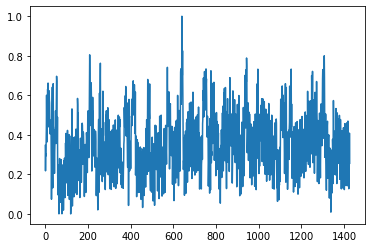

In [39]:
res_data['REV OBD'].plot()

### Calculate baseline error
* Baseline model that uses last known target value to make prediction.

In [41]:
# Validation set의 정답지만 모아서 실제 관측치 만들기
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

[torch.Size([64, 20]),
 torch.Size([64, 20]),
 torch.Size([64, 20]),
 torch.Size([64, 20]),
 torch.Size([64, 20]),
 torch.Size([64, 20]),
 torch.Size([25, 20])]

In [49]:
baseline_predictions.shape

torch.Size([409, 20])

In [65]:
baseline_predictions = Baseline().predict(val_dataloader)
# 모두 같은 값으로 예측됨 (Input vector의 마지막값)
baseline_predictions

tensor([[0.3407, 0.3407, 0.3407,  ..., 0.3407, 0.3407, 0.3407],
        [0.4908, 0.4908, 0.4908,  ..., 0.4908, 0.4908, 0.4908],
        [0.3246, 0.3246, 0.3246,  ..., 0.3246, 0.3246, 0.3246],
        ...,
        [0.4568, 0.4568, 0.4568,  ..., 0.4568, 0.4568, 0.4568],
        [0.3325, 0.3325, 0.3325,  ..., 0.3325, 0.3325, 0.3325],
        [0.3446, 0.3446, 0.3446,  ..., 0.3446, 0.3446, 0.3446]])

In [66]:
SMAPE()(baseline_predictions, actuals)

tensor(0.4222)

In [70]:
pl.seed_everything(42)
net = DeepAR.from_dataset(   # 데이터셋에 적용한 설정을 그대로 가져와 자동으로 DeepAR 네트워크에 적용
    training,
    learning_rate = 3e-2,
    hidden_size = 200,
    rnn_layers =2,
    loss = NormalDistributionLoss()   # class가 아닌 함수를 전달해 줘야 함 => 클래스는 맞지만 클래스의 인스턴스가 아니라 클래스 자체를 전달
)

Global seed set to 42
Global seed set to 42
Global seed set to 42


In [91]:
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=True, mode='min')
lr_logger = LearningRateMonitor()

In [92]:
trainer = pl.Trainer(
    max_epochs = 100,
    gpus = 1,
    weights_summary = 'top',  # 'top'은 무슨 의미?    => 탑레벨의 summary만 하라는 의미
    gradient_clip_val = .01,
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches = 30,
    enable_checkpointing = True,
    logger = logger
    # auto_lr_find = True
)

GPU available: True, used: True
GPU available: True, used: True
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


In [93]:
trainer.fit(
    net,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 0     
3 | rnn                    | LSTM                   | 484 K 
4 | distribution_projector | Linear                 | 402   
------------------------------------------------------------------
484 K     Trainable params
0         Non-trainable params
484 K     Total params
1.938     Total estimated model params size (MB)

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList        

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: -0.772
Metric val_loss improved. New best score: -0.772
Metric val_loss improved. New best score: -0.772


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: -0.772. Signaling Trainer to stop.
Monitored metric val_loss did not improve in the last 5 records. Best score: -0.772. Signaling Trainer to stop.
Monitored metric val_loss did not improve in the last 5 records. Best score: -0.772. Signaling Trainer to stop.


In [94]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = net.load_from_checkpoint(best_model_path)

In [95]:
best_model_path

'./DeepAR/version_0/checkpoints/epoch=5-step=84.ckpt'

In [96]:
best_model

DeepAR(
  (loss): NormalDistributionLoss()
  (logging_metrics): ModuleList(
    (0): SMAPE()
    (1): MAE()
    (2): RMSE()
    (3): MAPE()
    (4): MASE()
  )
  (embeddings): MultiEmbedding(
    (embeddings): ModuleDict()
  )
  (rnn): LSTM(1, 200, num_layers=2, batch_first=True, dropout=0.1)
  (distribution_projector): Linear(in_features=200, out_features=2, bias=True)
)

In [97]:
SMAPE()(predictions, actuals)

tensor(0.2649)

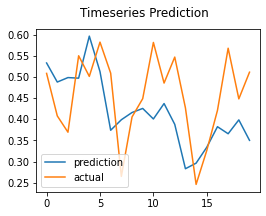

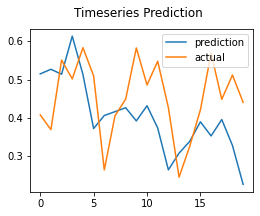

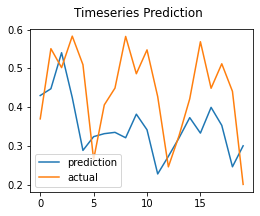

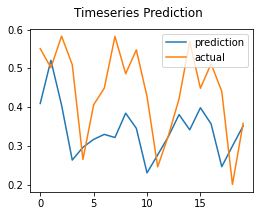

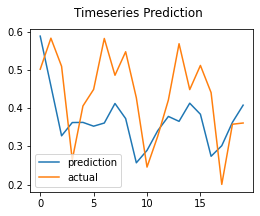

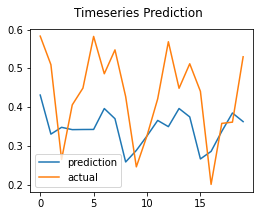

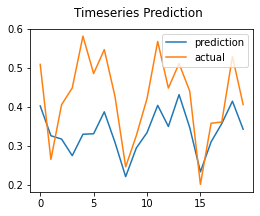

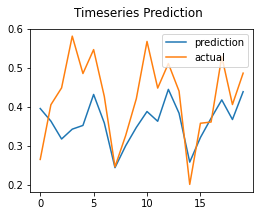

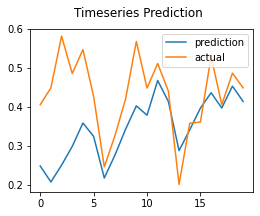

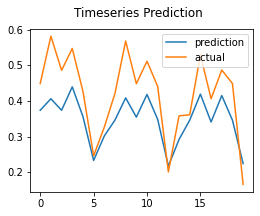

In [98]:
for i in np.arange(10, 20):
    plt.figure(figsize=(4, 3))
    plt.plot(predictions[i], label='prediction')
    plt.plot(actuals[i], label='actual')
    plt.suptitle('Timeseries Prediction')
    plt.legend()
    plt.show()

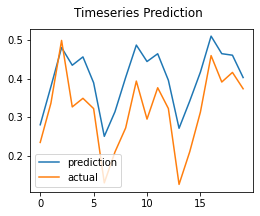

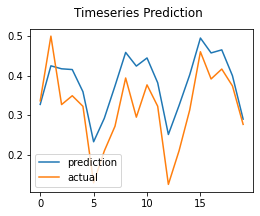

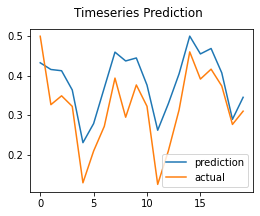

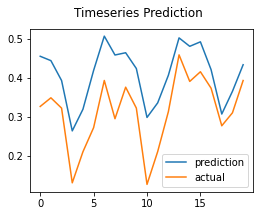

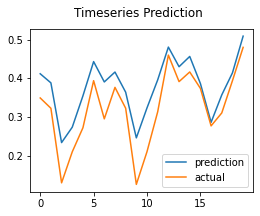

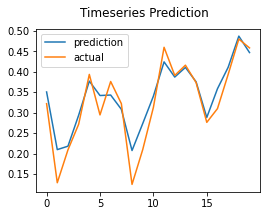

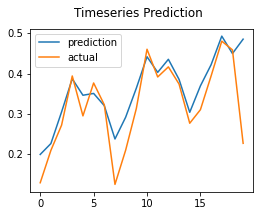

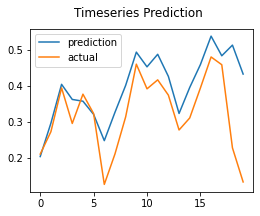

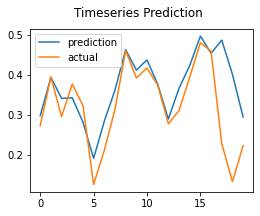

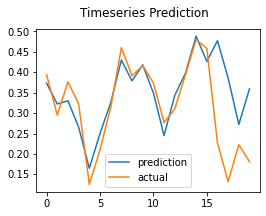

In [99]:
raw_predictions, x = net.predict(val_dataloader, return_x=True, n_samples=100)
for i in np.arange(60, 70):
  plt.figure(figsize=(4, 3))
  plt.plot(raw_predictions[i], label='prediction')
  plt.plot(actuals[i], label='actual')
  plt.suptitle('Timeseries Prediction')
  plt.legend()
  plt.show()